<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_1_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datos Trabajo de Grado

Andrés Mora

### Introducción

El Cboe Volatility Index® (VIX® Index) es un índice de referencia que sirve para medir las expectativas del mercado sobre la volatilidad futura. El índice VIX se calcula con base en las opciones del índice S&P 500. El índice VIX es reconocido como el principal indicador mundial de la volatilidad del mercado de valores de E.U.

El índice VIX se utiliza como barómetro de la incertidumbre del mercado, proporcionando a los participantes del mercado una medida de la volatilidad esperada constante a 30 días del mercado de valores de E.U.

Por ser de gran importancia, este trabajo tendrá el fin de predecir la serie de tiempo del VIX. Las fechas se dejan a consideración del usuario, teniendo así 80% para entrenamiento, 10% para validar y 10% para prueba.

https://www.cboe.com/tradable_products/vix/faqs/

https://www.spglobal.com/spdji/en/vix-intro/

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
!pip install -q keras-tcn --no-dependencies
from tcn import TCN, tcn_full_summary

In [ ]:
import tensorflow_probability as tfp
print(tfp.__version__)

0.21.0


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-probability

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 25.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.20.1
    Uninstalling tensorflow-probability-0.20.1:
      Successfully uninstalled tensorflow-probability-0.20.1


## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from tensorflow.keras.layers import Dense, GlobalMaxPooling1D, BatchNormalization, ReLU

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

In [2]:
import keras.layers
from keras import optimizers
from keras.layers import Activation, Lambda, Input
from keras.layers import Conv1D, SpatialDropout1D, Flatten, ZeroPadding1D, TimeDistributed, ConvLSTM1D
from keras.layers import Convolution1D, Dense, Reshape
#from keras.models import Input, Model
from typing import List, Tuple
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ZeroPadding1D, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow_probability.python.layers import util as tfp_layers_util
from tensorflow.keras import layers

## Utilities

Gran parte de los códigos de funciones y preprocesamiento están basados en Moroney (2020).

You will be plotting the MAE and loss later so the `plot_series()` is extended to have more labelling functionality. The utilities for generating the synthetic data is the same as the previous labs.

In [3]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)



    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend, loc='upper right')

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Prepare Features and Labels

In [4]:
def windowed_dataset(series, window_size, batch_size):
#def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    #dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [5]:
#metricas
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics

rmse = tf.keras.metrics.RootMeanSquaredError()

mape = tf.keras.metrics.MeanAbsolutePercentageError()

msle = tf.keras.metrics.MeanSquaredLogarithmicError()

## Model Forecast

In [6]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

## Importar los datos

In [ ]:
#!pip install pandas_datareader
#!pip install yfinance

In [7]:
import yfinance as yf
from datetime import datetime, timedelta

##-- si quiero que empiece un cierto número de días antes de la fecha de hoy, y como fecha final el día de hoy

# Obtener la fecha de hoy
#today = datetime.now()

end_date = '2023-07-31'

#número de días (incluyen no laborales)
n_days = 3630   #para tener en total 2500 en la long del vix

# Calcular n días antes del día de hoy
fin_date = datetime.strptime(end_date, '%Y-%m-%d')
start_date = fin_date - timedelta(days=n_days)

# Formatear las fechas en el formato 'YYYY-MM-DD'
#start_date_str = start_date.strftime('%Y-%m-%d')
#end_date_str = today.strftime('%Y-%m-%d')

# Si quiero especificar el rango de fechas deseado
#start_date = '2017-02-01'  #1990-02-01
#end_date = '2023-08-08'

# Importar los datos del VIX de Yahoo Finance
vix_data = yf.download('^VIX', start=start_date, end=end_date)

vix_data.shape[0]

[*********************100%%**********************]  1 of 1 completed


2500

In [8]:
# Imprimir los primeros registros de los datos

vix = vix_data['Close']
print(vix.head())

Date
2013-08-22    14.76
2013-08-23    13.98
2013-08-26    14.99
2013-08-27    16.77
2013-08-28    16.49
Name: Close, dtype: float64


In [ ]:
print(vix.tail())

Date
2023-07-24    13.91
2023-07-25    13.86
2023-07-26    13.19
2023-07-27    14.41
2023-07-28    13.33
Name: Close, dtype: float64


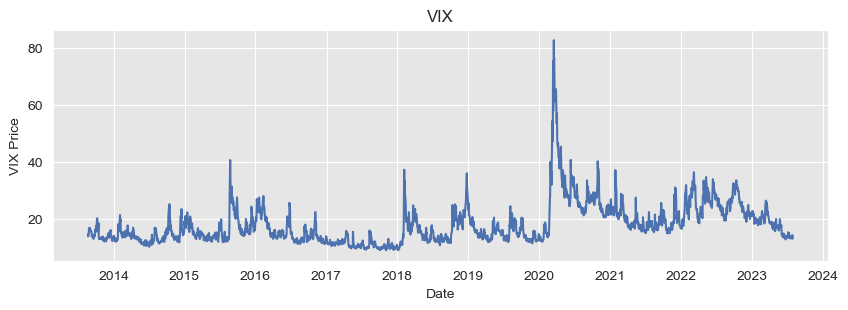

In [ ]:
# Graficar la serie de tiempo de vix_close
plt.figure(figsize=(10, 3))
plt.plot(vix)
plt.title('VIX')
plt.xlabel('Date')
plt.ylabel('VIX Price')
plt.grid(True)
plt.show()


# plot sin fechas
#time = np.array(range(len(vix)))
#plot_series(time, vix, xlabel='Time', ylabel='vix')

#### Análisis Exploratorio de los datos

In [ ]:
vix.describe()

El máximo valor del Vix ha sido 82,7 en marzo de 2020 efecto de la crisis COVID-19. Valores similares se registaron en la crisis subprime.

El mínimo valor fue de 9,14, con media de 19,62 y mediana de 17,80, mostrando una asimetría positiva, como se observa en el siguiente histograma.

Valores entre 15 y 25 se consideran moderados. Valores de Vix entre 25 y 30 se consideran altos.

In [ ]:
vix.hist()

In [ ]:
pd.DataFrame(vix).boxplot()

#se observan datos atípicos por encima del valor de 40
#Valores de Vix mayores que 30 se considera extremadamente alto indicando alta turbulencia en los mercados

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(vix)
plt.show()

#correlación serial de la serie del vix
#puede haber un patrón de dependencia a largo plazo

In [ ]:
# Partial Autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(vix, method='ywm')
plt.show()

#quitando correlaciones entre lags
#viendo acf y pacf, podría indicar un modelo AR(2)

## Split the Dataset

In [9]:
# Parameters
time = np.arange(vix_data.shape[0],dtype="float32")

#Percentage of train
pct_train = 0.8
pct_test = 0.9

# Define the split time
split_time = round(len(vix)*pct_train)
test_time = round(len(vix)*pct_test)

# Get the train set
time_train = time[:split_time]
x_train = vix[:split_time]

# Get the validation set

x_valid = vix[split_time:test_time]
time_valid = time[split_time:test_time]

# Get the test set

x_test = vix[test_time:]
time_test = time[test_time:]

In [ ]:
print(split_time)

2000


In [ ]:
len(vix)

2500

In [ ]:
print(test_time)

2250


In [ ]:
x_test.shape

(250,)

In [10]:
x_trainv = x_train.values
x_validv = x_valid.values
x_testv = x_test.values
x_train_norm = (x_trainv - np.median(x_trainv))/(np.percentile(x_trainv, 75)-np.percentile(x_trainv, 25))
x_valid_norm = (x_validv - np.median(x_trainv))/(np.percentile(x_trainv, 75)-np.percentile(x_trainv, 25))
x_test_norm = (x_testv - np.median(x_trainv))/(np.percentile(x_trainv, 75)-np.percentile(x_trainv, 25))

## Prepare Features and Labels

Experiment with different batch sizing here and see how it affects your results.

In [11]:
# Parameters
window_size = 20
batch_size = 512    #se puede incrementar si se observa gráficos de loss muy raros, i.e. con mucho rizado
#shuffle_buffer_size = 1000

In [12]:
# Generate the dataset windows
train_set = windowed_dataset(x_train_norm, window_size, batch_size)
valid_set = windowed_dataset(x_valid_norm, window_size, batch_size)
test_set = windowed_dataset(x_test_norm, window_size, batch_size)
#train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Modelos

### 3. TCN

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 20

model = keras.models.Sequential([
        TCN(input_shape=(window_size,1), nb_filters=64, return_sequences=True, dilations=[1, 2, 4, 8, 16],
            nb_stacks=1,kernel_size=3,use_skip_connections=True, padding="causal",activation="elu"),
        tf.keras.layers.LSTM(64), #64
        Dense(1,activation="elu")
    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 20, 64)            111552    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 144641 (565.00 KB)
Trainable params: 144641 (565.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(
    loss=keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["mae",rmse,mape,msle])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, mode='min')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, verbose=1, mode='min', min_lr=1e-30)

callbacks = [early_stopping, reduce_lr]

history = model.fit(train_set, batch_size=512, epochs=10000, callbacks=callbacks, validation_data=valid_set)

Epoch 1/10000
4/4 [==============================] - 7s 407ms/step - loss: 0.5063 - mae: 0.8140 - root_mean_squared_error: 1.3155 - mean_absolute_percentage_error: 310.3638 - mean_squared_logarithmic_error: 0.2559 - val_loss: 1.2627 - val_mae: 1.7366 - val_root_mean_squared_error: 1.9428 - val_mean_absolute_percentage_error: 148.6342 - val_mean_squared_logarithmic_error: 0.7730 - lr: 1.0000e-05
Epoch 2/10000
4/4 [==============================] - 0s 65ms/step - loss: 0.4917 - mae: 0.7950 - root_mean_squared_error: 1.3655 - mean_absolute_percentage_error: 314.6137 - mean_squared_logarithmic_error: 0.2814 - val_loss: 1.2261 - val_mae: 1.6937 - val_root_mean_squared_error: 1.9088 - val_mean_absolute_percentage_error: 140.3452 - val_mean_squared_logarithmic_error: 0.7705 - lr: 1.0000e-05
Epoch 3/10000
4/4 [==============================] - 0s 64ms/step - loss: 0.4778 - mae: 0.7777 - root_mean_squared_error: 1.3484 - mean_absolute_percentage_error: 303.4056 - mean_squared_logarithmic_error:

In [ ]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,mae,root_mean_squared_error,mean_absolute_percentage_error,mean_squared_logarithmic_error,val_loss,val_mae,val_root_mean_squared_error,val_mean_absolute_percentage_error,val_mean_squared_logarithmic_error,lr,epoch
645,0.047207,0.166022,0.404321,130.853195,0.010846,0.072127,0.292158,0.381038,35.323650,0.026095,1.000000e-06,645
646,0.047199,0.166006,0.404287,130.844498,0.010844,0.072135,0.292164,0.381059,35.324291,0.026097,1.000000e-06,646
647,0.047191,0.165989,0.404253,130.835632,0.010842,0.072143,0.292171,0.381082,35.324871,0.026099,1.000000e-06,647
648,0.047187,0.165980,0.404236,130.827255,0.010841,0.072143,0.292171,0.381084,35.324955,0.026099,1.000000e-07,648
649,0.047186,0.165978,0.404232,130.826309,0.010841,0.072144,0.292172,0.381087,35.325005,0.026099,1.000000e-07,649


In [ ]:
test_data_norm = pd.DataFrame(x_test_norm)
test_data_norm.columns = ['VixPrice_Norm']
test_data_norm.head()

,VixPrice_Norm
0,1.215315
1,1.380591
2,1.080364
3,1.003033
4,0.959060


In [ ]:
test_data_norm['y_pred']=df_yhat
test_data_norm['time'] = np.arange(0,250)
test_data_norm.head()

,VixPrice_Norm,y_pred,time
0,1.215315,0.594213,0
1,1.380591,0.656405,1
2,1.080364,0.544328,2
3,1.003033,0.516345,3
4,0.959060,0.500671,4


In [ ]:
test_metrics = model.evaluate(test_set)
test_loss = test_metrics[0]

1/1 [==============================] - 0s 72ms/step - loss: 0.0224 - mae: 0.1663 - root_mean_squared_error: 0.2118 - mean_absolute_percentage_error: 139.4735 - mean_squared_logarithmic_error: 0.0113


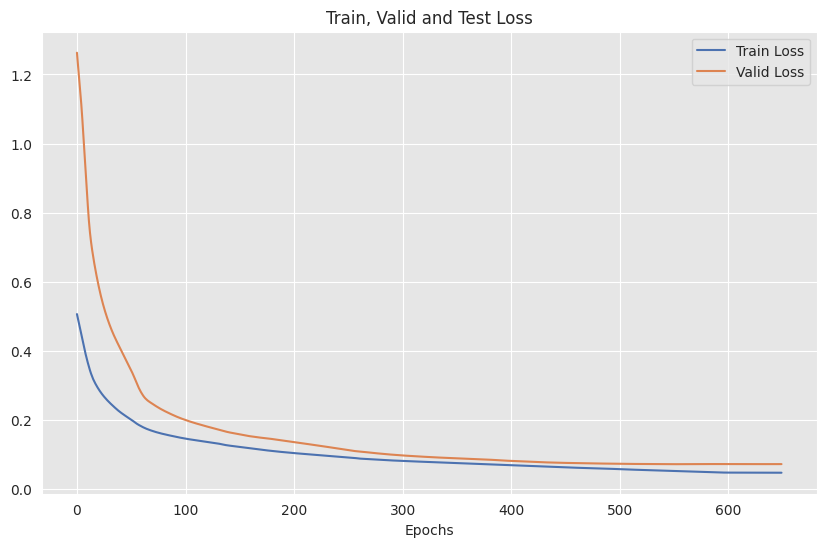

In [ ]:
loss_train=history.history['loss']
loss_valid=history.history['val_loss']


# Get number of epochs
epochs=range(len(loss_train))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(loss_train, loss_valid),
    title='Train, Valid and Test Loss',
    xlabel='Epochs',
    legend=['Train Loss', 'Valid Loss'],
    )

In [ ]:
for x, y in test_set:
    z = model.predict(x)

7/7 [==============================] - 1s 21ms/step


In [ ]:
x_test_norm_rec = x_test_norm[-219:]

In [ ]:
y_pred_orig = z*(np.percentile(x_trainv, 75)-np.percentile(x_trainv, 25)) + np.median(x_trainv)
y_true_orig = x_test_norm_rec*(np.percentile(x_trainv, 75)-np.percentile(x_trainv, 25)) + np.median(x_trainv)

<Figure size 1000x600 with 0 Axes>

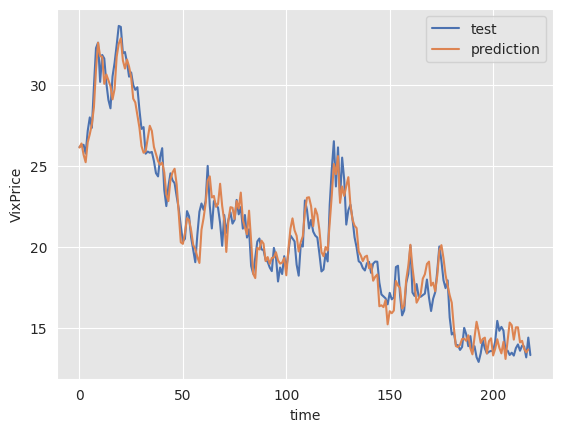

In [ ]:
# Setup dimensions of the graph figure
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
g1 = ax.plot(y_true_orig , label = "test")
g2 = ax.plot(y_pred_orig , label= "prediction")

plt.ylabel("VixPrice")
plt.xlabel("time")
ax.legend(loc='upper right')
plt.show()

In [ ]:
####################### Fin #############################

### Bibliografía

Moroney, Laurence. AI and Machine Learning for coders. O'Reilly Media, 2020.
